# Finding a place for a new ruin pub in Budapest

## IBM Data Science Capstone Project

### Introduction/Business Problem

In the present research, I am looking to answer the following question: if an investor wants to open a so-called ruin pub in Budapest, then in which of the 23 districts of Budapest would it be worth opening the pub?

The ruin pub is a restaurant/pub developed from a ruined area, or building that is architecturally deliberately left in a ruined state. The Szimplakert, the first ruin pub in Budapest opened in 2004, followed by other pubs in the 7th district of Budapest and later spread to other inner districts. The interesting idea became an alternative fashion trend in Budapest and then quickly became very popular among tourists as well. From 2010 onwards, more and more new places have been opened, but **in my opinion it would still be worth opening another ruin pub, but in a saturated market, the location has to be chosen well.**

### Data to use

In the research, I will use the **Foursquare spatial data** to examine the most popular venues in each district, and use other data (e.g., population density, number of tourists, average property prices, etc.) to select the districts where it may be most worthwhile to open a ruin pub.

I will get the districts of Budapest and the coordinates from the wikipedia page of Budapest (https://hu.wikipedia.org/wiki/Budapest_ker%C3%BCletei). 

Besides the Foursquare data, i will use other **statistical data (guest nights)** to find the optimal place for the ruin pub. These datatables will be downloaded from the Hungarian Statistical Office's dedicated site for territorial data (http://statinfo.ksh.hu/).

The **average house prices** data will be downloaded from the following site: https://www.ingatlannet.hu/

### Methodology

The backbone of the research is the use of Foursqure spatial data. Using the Foursqure API, **the most important (trending) venues are collected in each of the the districts of Budapest**. The number of venues are collected in a 1000m circle to the center of each district, and limited to 100 venues per district. The collected **venues are classified into clusters using the k-means clustering algorithm**. My goal is to see which districts fall into a category based on Foursquare locations. Currently the 5th (Belvaros) and the 7th districts (Erzsebetvaros) have the most ruin pubs. There would be too much competition here, so it would probably not be a good idea to open another ruin pub here, but based on the cluster analysis, districts belonging to the same cluster as these districts may come into play.

This method will be supplemented with the analysis of statistical data. First, I will look at the **number of guest nights in each district**, which is one of the most important factors regarding the opening of a new ruin pub, because **the vast majority of visitors in these bars are tourists**, mostly foreigb tourists.

After that I will **analyze house prices by district**. The original plan would have been the analysis of rent costs but no data were available, so I started from the premise that there is a linear relationship between rent costs and house prices, so the rent costs are high where house prices are also high. Regarding the house prices **the better choice for the ruin pub will be the districts where housing prices are low**, so rent cost are likely to be low as well.

Ultimately, I will put the above analyzes side by side and so I will choose which districts are best suited to host a new ruin pub.

### Preparing the data

#### Importing the neccesary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# import Folium for map rendering
! pip install folium
import folium

print('Libraries imported.')

Libraries imported.


#### Preparing the data

First i need the district of Budapest. I got the data from the wikipedia page of the districts of Budapest (https://hu.wikipedia.org/wiki/Budapest_ker%C3%BCletei) and uploaded the xlsx file to my Github repository.

In [2]:
# Get the data from my Github repository

!wget -q -O 'budapest_district.xlsx' https://github.com/balou99/Coursera_Capstone/blob/master/budapest_district.xlsx
print('Data downloaded!')

Data downloaded!


In [3]:
# Create a pandas dataframe

budapest_data = pd.read_excel('budapest_district.xlsx')
budapest_data.head()

,district_num,district_name
0,13,Angyalfold
1,5,Belvaros
2,22,Budafok
3,1,Budavar
4,16,Cinkota


In [4]:
# See that we have all the 23 districts

budapest_data.shape

(23, 2)

Now i need the coordinates of the districts, which i got one-by-one from Openstreetmap and put them into an xlsx and uploaded it into the Github repository.

In [5]:
# Get the coordinates for the districts

!wget -q -O 'budapest_coord.xlsx' https://github.com/balou99/Coursera_Capstone/blob/master/budapest_coord.xlsx
print('Data downloaded!')

Data downloaded!


In [6]:
# Create a pandas dataframe from the coordinates

budapest_coordinates = pd.read_excel('budapest_coord.xlsx')
budapest_coordinates.head()

,district_num,latitude,longitude
0,1,47.497500,19.038050
1,2,47.516667,19.016667
2,3,47.566667,19.033333
3,4,47.566667,19.083333
4,5,47.500000,19.048611


In [7]:
# See that we have all the 23 districts

budapest_coordinates.shape

(23, 3)

In [8]:
# Merge the two tables

budapest_data_final = pd.merge(budapest_data, budapest_coordinates, how='inner', on='district_num')
budapest_data_final.head()

,district_num,district_name,latitude,longitude
0,13,Angyalfold,47.532778,19.066111
1,5,Belvaros,47.500000,19.048611
2,22,Budafok,47.421986,19.024403
3,1,Budavar,47.497500,19.038050
4,16,Cinkota,47.520278,19.173889


In [9]:
# See that we have all the 23 districts

budapest_data_final.shape

(23, 4)

### Clustering the neighbourhoods of Budapest

#### Creating the map

In [10]:
# Install Geopy

! pip install geopy

In [13]:
# Import Geopy Nominatim to convert an address into latitude and longitude values

from geopy.geocoders import Nominatim
print('Geopy Nominatim imported')

Geopy Nominatim imported


In [14]:
# Get the address

address = 'Budapest, HU'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Budapest are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Budapest are 47.48138955, 19.14607278448202.


In [15]:
# create map of Budapest using latitude and longitude values

map_budapest = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map

for lat, lng, dist in zip(budapest_data_final['latitude'], budapest_data_final['longitude'], budapest_data_final['district_name']):
    label = '{}'.format(dist)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_budapest)  
    
map_budapest

Because github do not display maps, here is a link to the map: https://github.com/balou99/Coursera_Capstone/blob/master/map_bp.png

#### Exploring the neighborhoods in Budapest

In [16]:
# Define Foursquare Credentials

CLIENT_ID = 'OH2OZ0U3J2L5HDYISCXDEF4FMWGDFMIZ4X3EVKVQ5QVJFEOD' # Foursquare ID
CLIENT_SECRET = 'PTSJ2PNTOVNTEFYTOVSOTVTDB0VYHY2X5UYWLJ02IUDQ533P' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentails:
CLIENT_ID: OH2OZ0U3J2L5HDYISCXDEF4FMWGDFMIZ4X3EVKVQ5QVJFEOD
CLIENT_SECRET:PTSJ2PNTOVNTEFYTOVSOTVTDB0VYHY2X5UYWLJ02IUDQ533P


In [17]:
# Create function to get venues

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
# Run the function on the database

budapest_venues = getNearbyVenues(names=budapest_data_final['district_name'],
                                   latitudes=budapest_data_final['latitude'],
                                   longitudes=budapest_data_final['longitude']
                                  )

print ('Venues collected')

Angyalfold
Belvaros
Budafok
Budavar
Cinkota
Csepel
Erzsebetvaros
Ferencvaros
Hegyvidek
Jozsefvaros
Kispest
Kobanya
Obuda
Pesterzsebet
Pestszentlorinc
Rakosmente
Rakospalota
Rozsadomb
Soroksar
Terezvaros
Ujbuda
Ujpest
Zuglo
Venues collected


In [20]:
# Let's see how many venues were collected

budapest_venues.shape

(1273, 7)

There were 1273 venues collected. Let's see the number of venues per district.

In [21]:
# Number of venues per district

budapest_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Angyalfold,100,100,100,100,100,100
Belvaros,100,100,100,100,100,100
Budafok,25,25,25,25,25,25
Budavar,100,100,100,100,100,100
Cinkota,34,34,34,34,34,34
Csepel,20,20,20,20,20,20
Erzsebetvaros,100,100,100,100,100,100
Ferencvaros,66,66,66,66,66,66
Hegyvidek,48,48,48,48,48,48


We have 7 districts where we reached the maximum of 100 venues. The district with the least venues is Soroksar with 5.

In [22]:
# Number of unique categories

print('There are {} uniques categories.'.format(len(budapest_venues['Venue Category'].unique())))

There are 238 uniques categories.


### Analyze each district

In [23]:
# one hot encoding
budapest_onehot = pd.get_dummies(budapest_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
budapest_onehot['District'] = budapest_venues['District'] 

# move district column to the first column
fixed_columns = [budapest_onehot.columns[-1]] + list(budapest_onehot.columns[:-1])
budapest_onehot = budapest_onehot[fixed_columns]

# group rows by districts and by taking the mean of the frequency of occurrence of each category
budapest_grouped = budapest_onehot.groupby('District').mean().reset_index()
budapest_grouped

,District,Accessories Store,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Baseball Field,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Camera Store,Candy Store,Carpet Store,Castle,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Spot,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gastropub,General Entertainment,General Travel,German Restaurant,Gift Shop,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kids Store,Korean Restaurant,Lake,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Music Venue,Nature Preserve,Neighborhood,Night Market,Nightclub,Office,Optical Shop,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Pub,Radio Station,Record Shop,Restaurant,River,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Ski Trail,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Squash Court,Stadium,Steakhouse,Street Food Gathering,Student Center,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio
0,Angyalfold,0.00000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.030000,0.000000,0.000000,0.000000,0.000000,0.01,0.01,0.030000,0.000000,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.01,0.000000,0.00,0.010000,0.000000,0.010000,0.000000,0.01,0.040000,0.00,0.000000,0.00000,0.00,0.040000,0.00,0.00,0.000000,0.000000,0.00,0.080000,0.00,0.00,0.000000,0.010000,0.000000,0.00,0.00,0.000000,0.000000,0.010000,0.000000,0.000000,0.020000,0.040000,0.000000,0.000000,0.000000,0.00,0.000000,0.030000,0.040000,0.00,0.000000,0.0,0.000000,0.020000,0.00,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.00,0.00,0.020000,0.000000,0.010000,0.000000,0.000000,0.01000

In [24]:
budapest_grouped.shape

(23, 239)

In [25]:
# Function to sort venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
# Create new dataframe and display the top 10 venues for each district

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = budapest_grouped['District']

for ind in np.arange(budapest_grouped.shape[0]):
    district_venues_sorted.iloc[ind, 1:] = return_most_common_venues(budapest_grouped.iloc[ind, :], num_top_venues)

district_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Angyalfold,Coffee Shop,Gym / Fitness Center,Café,Pizza Place,Electronics Store,Diner,Chinese Restaurant,Indian Restaurant,Pub,Grocery Store
1,Belvaros,Hotel,Hungarian Restaurant,Coffee Shop,Italian Restaurant,Wine Bar,Ice Cream Shop,Modern European Restaurant,Plaza,Bakery,Japanese Restaurant
2,Budafok,Bus Stop,Bus Station,Food & Drink Shop,Tennis Court,Scenic Lookout,Grocery Store,Gun Range,Flower Shop,Gym / Fitness Center,Park
3,Budavar,Hotel,Café,Plaza,Coffee Shop,Hungarian Restaurant,Scenic Lookout,Pub,Dessert Shop,Wine Bar,Italian Restaurant
4,Cinkota,Bus Stop,Grocery Store,Park,Gym / Fitness Center,Sporting Goods Shop,Scenic Lookout,Supermarket,Bus Station,Café,Falafel Restaurant


#### Clustering the neighbourhoods

In [27]:
# Run k-means to cluster the district into 4 clusters

# set number of clusters
clusters = 4

budapest_grouped_clustering = budapest_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(budapest_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 0, 2, 1, 0, 0, 2, 0])

In [28]:
# add clustering labels
district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
district_venues_sorted

,Cluster Labels,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Angyalfold,Coffee Shop,Gym / Fitness Center,Café,Pizza Place,Electronics Store,Diner,Chinese Restaurant,Indian Restaurant,Pub,Grocery Store
1,0,Belvaros,Hotel,Hungarian Restaurant,Coffee Shop,Italian Restaurant,Wine Bar,Ice Cream Shop,Modern European Restaurant,Plaza,Bakery,Japanese Restaurant
2,1,Budafok,Bus Stop,Bus Station,Food & Drink Shop,Tennis Court,Scenic Lookout,Grocery Store,Gun Range,Flower Shop,Gym / Fitness Center,Park
3,0,Budavar,Hotel,Café,Plaza,Coffee Shop,Hungarian Restaurant,Scenic Lookout,Pub,Dessert Shop,Wine Bar,Italian Restaurant
4,2,Cinkota,Bus Stop,Grocery Store,Park,Gym / Fitness Center,Sporting Goods Shop,Scenic Lookout,Supermarket,Bus Station,Café,Falafel Restaurant
5,1,Csepel,Bus Stop,Park,Dessert Shop,Soccer Field,Plaza,Diner,Food,Bus Station,Supermarket,Pharmacy
6,0,Erzsebetvaros,Bar,Bakery,Coffee Shop,Hungarian Restaurant,Restaurant,Bistro,Café,Wine Bar,Hostel,Hotel
7,0,Ferencvaros,Music Venue,Electronics Store,Train Station,Concert Hall,Soccer Field,Diner,Playground,Fast Food Restaurant,Café,Furniture / Home Store
8,2,Hegyvidek,Bus Stop,Platform,Park,Grocery Store,Scenic Lookout,Playground,Bakery,Farmers Market,Steakhouse,Pharmacy
9,0,Jozsefvaros,Coffee Shop,Hotel,Wine Bar,Bar,Café,Electronics Store,Ice Cream Shop,Vietnamese Restaurant,Pizza Place,Italian Restaurant


In [30]:
# merge budapest_grouped with budapest_data to add latitude/longitude for each district

budapest_merged = budapest_data_final.join(district_venues_sorted)
budapest_merged.head()

,district_num,district_name,latitude,longitude,Cluster Labels,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,13,Angyalfold,47.532778,19.066111,0,Angyalfold,Coffee Shop,Gym / Fitness Center,Café,Pizza Place,Electronics Store,Diner,Chinese Restaurant,Indian Restaurant,Pub,Grocery Store
1,5,Belvaros,47.500000,19.048611,0,Belvaros,Hotel,Hungarian Restaurant,Coffee Shop,Italian Restaurant,Wine Bar,Ice Cream Shop,Modern European Restaurant,Plaza,Bakery,Japanese Restaurant
2,22,Budafok,47.421986,19.024403,1,Budafok,Bus Stop,Bus Station,Food & Drink Shop,Tennis Court,Scenic Lookout,Grocery Store,Gun Range,Flower Shop,Gym / Fitness Center,Park
3,1,Budavar,47.497500,19.038050,0,Budavar,Hotel,Café,Plaza,Coffee Shop,Hungarian Restaurant,Scenic Lookout,Pub,Dessert Shop,Wine Bar,Italian Restaurant
4,16,Cinkota,47.520278,19.173889,2,Cinkota,Bus Stop,Grocery Store,Park,Gym / Fitness Center,Sporting Goods Shop,Scenic Lookout,Supermarket,Bus Station,Café,Falafel Restaurant


### Create map with clusters

In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(clusters)
ys = [i + x + (i*x)**2 for i in range(clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(budapest_merged['latitude'], budapest_merged['longitude'], budapest_merged['district_name'], budapest_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)

In [31]:
map_clusters

Because github do not display maps, here is a link to the map: https://github.com/balou99/Coursera_Capstone/blob/master/map_cluster.png

### Plotting the tourism data

In [32]:
# Import matplotlib

%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

In [33]:
# Get the data from my Github repository

!wget -q -O 'budapest_stat.xlsx' https://github.com/balou99/Coursera_Capstone/blob/master/budapest_stat.xlsx
print('Data downloaded!')

Data downloaded!


In [34]:
# Create a pandas dataframe

budapest_stats = pd.read_excel('budapest_stat.xlsx')
budapest_stats.head()

,district_num,price,overnight
0,5,1184405,2112319
1,1,1011686,582984
2,12,945088,217303
3,2,936647,337334
4,6,904124,942133


In [35]:
# Drop the price column for now

budapest_tourism = budapest_stats.drop(['price'], axis=1)
budapest_tourism.head()

,district_num,overnight
0,5,2112319
1,1,582984
2,12,217303
3,2,337334
4,6,942133


In [36]:
# Set the index to the district number
budapest_tourism = budapest_tourism.set_index('district_num')

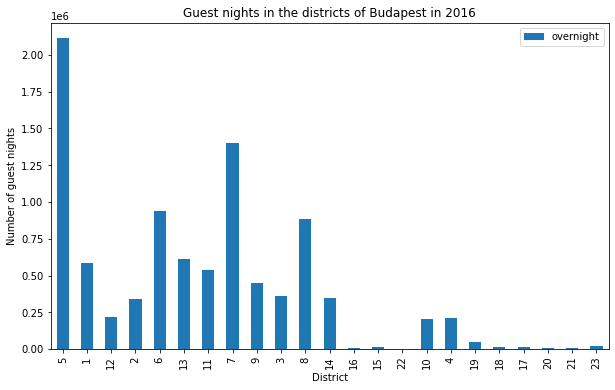

In [37]:
# plot the data

budapest_tourism.plot(kind='bar', figsize=(10, 6))

plt.xlabel('District') # add to x-label to the plot
plt.ylabel('Number of guest nights') # add y-label to the plot
plt.title('Guest nights in the districts of Budapest in 2016') # add title to the plot

plt.show()

### Plotting the housing prices data

In [38]:
# We will use the previously imported budapest_stat dataframe and drop the tourism column

budapest_house = budapest_stats.drop(['overnight'], axis=1)
budapest_house.head()

,district_num,price
0,5,1184405
1,1,1011686
2,12,945088
3,2,936647
4,6,904124


In [39]:
# Set the index to the district number
budapest_house = budapest_house.set_index('district_num')

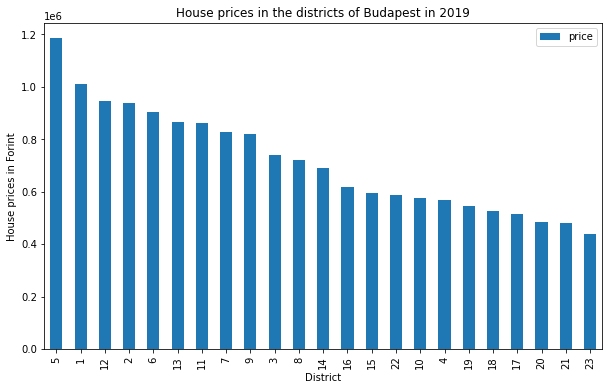

In [40]:
# Plot the data

budapest_house.plot(kind='bar', figsize=(10, 6))

plt.xlabel('District') # add to x-label to the plot
plt.ylabel('House prices in Forint') # add y-label to the plot
plt.title('House prices in the districts of Budapest in 2019') # add title to the plot

plt.show()

### Results

**Clustering:**  
I decided to go with 4 clusters and after the k-means clustering the four groups were the following:  
    - *Cluster 0* contained 11 districts including the 7th distrcit (Erzsebetvaros) and the 5th district (Belvaros)with mostly café shops, bars and hotels in first places. Looking at the map we can se that these are the inner districts of Budapest  
    - *Cluster 1* contained 5 districts with mostly grocery stores, bus tops and parks in first places  
    - *Cluster 2* contained 6 districts including the with very similar characteristics to the *Cluster 1* but further from the city center  
    - *Cluster 3* contained only 1 district (Soroksar) which is the most rural district of Budapest so that farm come in first place is not a surprise  
  
**Guest nights:**  
So we can see that the **most guest nights are in those districts where the majority of ruin pubs are located (5th and 7th).** So the hypothesis that there is a strong correlation between the number of ruin pubs and the number of guest nights is probably right.
**Other districts with a lot of guest nights are the 6th, 8th** followed by the 13th, 1st and 11th. 
From 15th to 23rd districts there are much fewer guest nights and it is not a surprise becase those are the outer districts.  
  
**House prices:**  
The house prices are clearly the highest in the 5th district followed by the 1st, 12th, 2nd and 6th. 

### Discussion and conclusion

We have the results from the clustering and the analysis of guest nights and house prices. It is time to compare the results and pick a district (or districts) for the ruin pub.    
**First we cut the suitable locations according to the cluster analysis.** As we mentioned earlier the districts with the most ruin pubs today are the 7th distrcit (Erzsebetvaros) and the 5th district (Belvaros). So we assume that districts in their clusters are the best suited for the new ruin pub. That way **we can drop 12 districts from the suitable locations, and have the 11 districts from *Cluster 1*.**  

Now we know that there is a strong correlation between the **guest nights** and the number of ruin pubs, so let's choose the districts with the most guest nights. As we can see from the bar chart there are **four districts with high values: 5th, 7th, 6th, 8th.**  

Looking at the house prices its clear that the lowest prices are in the outer districts which were excluded in the cluster analysis. **From the 11 districts in *Cluster 1* the lowest prices are in the 4th, 8th and 10th districts.**  

So looking at the results of our analysis and putting together the data **there is only one districts that got everything we are looking for: District 8th (Jozsefvaros).**
It is in *Cluster 0*, there were a lot of guest nights in 2016 and the house prices (and thus the rent costs) are one of the lowest from the inner districts. **So it is the perfect place to open a new ruin pub.**